## Clustering

https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d/

In [1]:
import os
import math
import numpy as np
import pyspark.sql.functions as sql_f

from graphframes import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from scipy.spatial import distance
from pyspark.sql.functions import col, substring
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import substring
from pyspark.sql.functions import size, col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import Row
from itertools import combinations

# Variable de entorno. Modificar en caso de disponer de varias
# versiones de Java instaladas.
os.environ["JAVA_HOME"] = r"/home/cristhian/Descargas/OpenJDK8U-jdk_x64_linux_hotspot_8u452b09/jdk8u452-b09"

In [2]:
# Definición del entorno de ejecución
CORES = 12 # Número de núcleos de CPU a usar
PARTS = 12 # Número de particiones del dataset (para hacer repartition)
FRAC = 0.2 # Fracción de los datos aleatoriamente seleccionados
DIMS = 14  # Número de componentes PCA seleccionadas en base a mayor varianza explicada

spark = (
    SparkSession.builder.master(f"local[{CORES}]")
    .appName(f"Local DT con {CORES} particiones")
    .config("spark.driver.memory", "24g")
    .config("spark.executor.memory", "24g")
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")

    .getOrCreate()
)
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/graphframes-checkpoints")

:: loading settings :: url = jar:file:/home/cristhian/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/cristhian/.ivy2/cache
The jars for the packages stored in: /home/cristhian/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9e290e16-de2d-419c-9db6-51ff5c0ca21d;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 96ms :: artifacts dl 3ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------------------

### Lectura de datos (provisional)

In [3]:
# Lectura del dataset
df = spark.read.format('csv') \
    .option('header', 'true') \
    .option('delimiter', ',') \
    .load('spotify_songs.csv') \
    .repartition(PARTS)

# Lista de columnas a convertir
cols_to_convert = [
    "track_popularity", "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness", "valence",
    "tempo", "duration_ms"
]

# Castea las columnas especificadas a DoubleType
for c in cols_to_convert:
    df = df.withColumn(c, col(c).cast(DoubleType()))


# Filtrado de géneros incorrectos
valid_genres = ['pop', 'rock', 'rap', 'edm', 'r&b', 'latin']
df = df.filter(col('playlist_genre').isin(valid_genres))
df.select('playlist_genre').distinct().show()
print("Número de géneros únicos:", df.select(
    'playlist_genre').distinct().count())

cols_to_drop = [
    'track_id', 'track_name', 'track_artist',
    'track_album_id', 'track_album_name',
    'playlist_name', 'playlist_id'
]

df = df.drop(*cols_to_drop).cache()

+--------------+
|playlist_genre|
+--------------+
|           r&b|
|           pop|
|           edm|
|           rap|
|          rock|
|         latin|
+--------------+

Número de géneros únicos: 6


In [4]:
def one_hot_preprocess(df, categorical_cols):

    indexers = [StringIndexer(inputCol=col, outputCol=col +
                              '_idx', handleInvalid='keep') for col in categorical_cols]
    encoders = [OneHotEncoder(
        inputCol=col + '_idx', outputCol=col + '_ohe') for col in categorical_cols]

    pipeline = Pipeline(stages=indexers + encoders)
    return pipeline.fit(df).transform(df)

In [5]:
categorical_cols = ['playlist_genre']
df = one_hot_preprocess(df, categorical_cols=categorical_cols)


# Extraer el año de la fecha (formato 'YYYY-MM-DD')
df = df.withColumn("release_year", substring(
    "track_album_release_date", 1, 4).cast("int"))

df = df.drop('playlist_genre', 'playlist_subgenre', 'track_album_release_date')

In [6]:
categorical_cols = ['playlist_genre']
idx_cols = [col + '_idx' for col in categorical_cols]
df = df.drop(*idx_cols)

In [7]:
# Convertir vectores a arrays
df = df.withColumn("playlist_genre_array",
                   vector_to_array("playlist_genre_ohe"))

# Obtener tamaños
genre_length = df.select(
    size("playlist_genre_array").alias("size")).first()["size"]

# Usar los tamaños directamente en los loops
for i in range(genre_length):
    df = df.withColumn(f"playlist_genre_{i}", col(
        "playlist_genre_array").getItem(i))

# Eliminar las variables redundantes
df = df.drop('playlist_genre_ohe', 'playlist_genre_array')

In [8]:
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df = assembler.transform(df)

scaler = StandardScaler(
    inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

df.show(10, truncate=False)

25/04/23 13:41:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+------------+----------------+----------------+----------------+----------------+----------------+----------------+------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|release_year|playlist_genre_0|playlist_genre_1|playlist_genre_2|playlist_genre_3|playlist_genre_4|

In [9]:
from pyspark.ml.feature import PCA

pca = PCA(k=DIMS, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df)

25/04/23 13:41:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/23 13:41:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
25/04/23 13:41:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/04/23 13:41:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [10]:
# Aplicamos pca

pca_data = pca_model.transform(df).cache()

# **Insertar aqui arriba notebook de preprocesado**

In [11]:
df_pca = pca_data.select("pca_features")
df_sampled = df_pca.sample(withReplacement=False, fraction=FRAC, seed=123456)

In [12]:
# Muestreamos el dataset
df_sampled.show(10)

+--------------------+
|        pca_features|
+--------------------+
|[1.03017884414143...|
|[-0.0427136914779...|
|[-0.6210886560872...|
|[-0.1329196266984...|
|[0.89009594693290...|
|[1.32304249784103...|
|[1.14238077669457...|
|[-1.0841473135196...|
|[0.91231978396713...|
|[-1.2163972853543...|
+--------------------+
only showing top 10 rows



In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import monotonically_increasing_id

# Añadimos la ID al comienzo de la línea
df_sampled = df_sampled.withColumn("id", monotonically_increasing_id())
df_preproc = df_sampled.select("id", "pca_features")

# Renombramos la columna por un nombre genérico como value
df_preproc = df_preproc.withColumnRenamed("pca_features", "value")

# Mostrar el resultado
df_preproc.show(truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |value                                                                                                                                                                                                                                                                                  |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0  |[1.0301788441414357,-1.6876705671596075,-1.5659708461267305,-0.14016921892932588,-0.08213975028806403,-1.0382712555882476,1.2454212250484

# Código de DBScan original

In [14]:
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations

def __distance_from_pivot(pivot, dist, epsilon, operations):
"""
Genera una función que asigna un punto a una partición según su distancia al pivote.

:param pivot: Valor del pivote para calcular distancias.
:param dist: Función de distancia que toma dos valores y retorna una distancia numérica.
:param epsilon: Umbral de distancia para crear particiones.
:param operations: (Opcional) Objeto para contar operaciones de distancia, con método `add()`.
:return: Función que toma un objeto `x` y retorna una lista de tuplas con índice de partición y lista de `Row`s.
"""
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    def scan(x):
        # out dictionary would have point id as key and a set of point ids who are within epsilon distance to
        # key point id. value is basically its neighbors
        out = {}
        # 0th index of x is partition_index
        # 1st index of x is data points
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # both i and j are within epsilon distance to each other
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # returns point and its neighbor as tuple
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


def __label(min_pts):
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # use id as cluster label
            cluster_label = x[0]
            # return True for core point
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # return False for base point
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label


def __combine_labels(x):
    # 0th element is the id of point
    # 1st element is the list of tuples with cluster and core point label
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumulator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    zero = df.rdd.takeSample(False, 1)[0].value
    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    try:
        id_cluster_df = id_cluster_rdd.toDF()
        vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item)
                    for item in x[1]]).toDF().distinct()
        edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct()
        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()
        id_cluster_df = id_cluster_df.\
            join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")
        return id_cluster_df
    except ValueError:
        return None

In [15]:
# Ejecución del algoritmo
df_clusters = process(spark, df_preproc, 2, 20,
                      distance.euclidean, DIMS, "checkpoint")

In [16]:
np.unique(np.array(df_clusters.toPandas()["component"]), return_counts=True)

(array([  2,   4,  26,  42,  77,  94, 158, 281, 285, 313, 317, 343]),
 array([312, 514, 415, 294, 365, 476,  50, 331, 383, 305, 461, 264]))

In [17]:
np.sum(np.unique(np.array(df_clusters.toPandas()
       ["component"]), return_counts=True)[1])

4170

In [18]:
df_joined = df_preproc.join(df_clusters, df_preproc.id == df_clusters.point)
df_joined

DataFrame[id: bigint, value: vector, point: bigint, component: bigint, core_point: boolean]

In [19]:
df_results = df_joined.select("id", "value", "component").toPandas()
df_results

,id,value,component
0,85899346120,"[-0.35393381778924893, -3.777717678332798, -1....",26
1,17179869192,"[0.03161319620264222, -3.0196622867757332, -2....",26
2,77309411854,"[0.9319970963551868, 1.0582056789626182, -1.82...",94
3,77309411466,"[-0.2807816715982636, 1.037835592354153, -1.34...",94
4,68719476910,"[-1.3522802092244572, 3.2435178428727327, -0.1...",42
...,...,...,...
4165,25769804333,"[-1.7458157164589685, -0.9191254121480434, -0....",343
4166,25769804104,"[-2.0935707225368105, -0.7494070704615681, 0.0...",343
4167,60129542464,"[-2.7641443831942984, -0.7699792504928569, -0....",343
4168,94489280901,"[0.11836162276441956, 0.2435683267068912, 0.40...",94


In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = np.array(df_results['value'].tolist())

# Crear un modelo PCA para reducir a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear un modelo TSNE para reducir a 2 componentes
tsne = TSNE(n_components=2, random_state=123456, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

# Agregar las componentes principales al DataFrame de Pandas
df_results['pca1'] = X_pca[:, 0]
df_results['pca2'] = X_pca[:, 1]
df_results['tsne1'] = X_tsne[:, 0]
df_results['tsne2'] = X_tsne[:, 1]

In [21]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_result(dataset, result_tags, file_name=None, style='ticks'):

    # data preparation
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags

    # sns preparation
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    # Plot raw points (without labels)
    sns.scatterplot(x='x', y='y', data=df, ax=axes[0], color='blue')
    axes[0].set_title('Puntos sin etiquetar')

    # Plot clustered points
    sns.scatterplot(x='x', y='y', data=df, hue='label',
                    ax=axes[1], palette='tab20')
    axes[1].set_title('Resultado del clustering')

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    if file_name:
        f.suptitle(f'DBSCAN Result of {file_name}', fontsize=14)

    plt.tight_layout()
    plt.show()

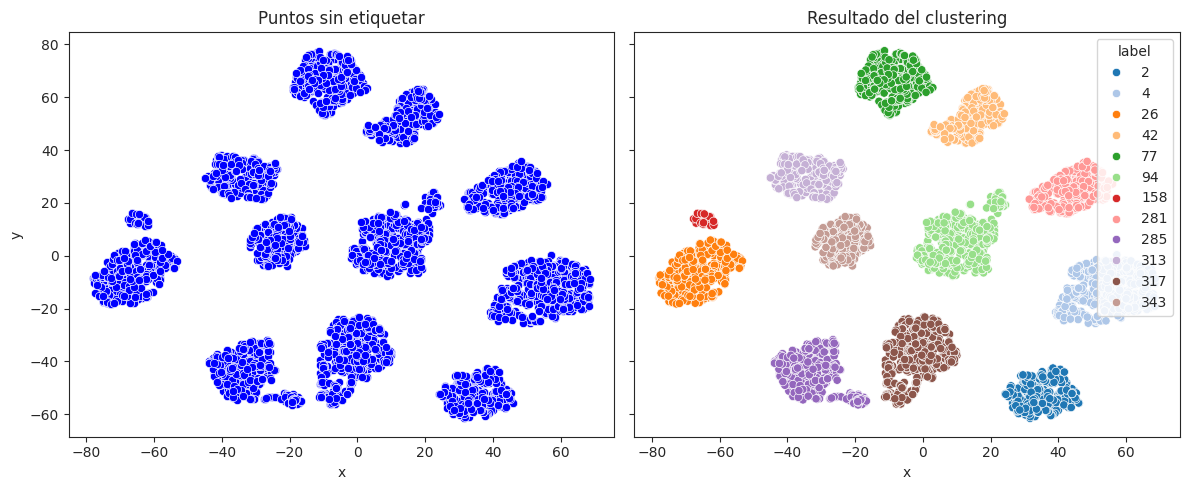

In [22]:
plot_result(X_tsne, df_results["component"])

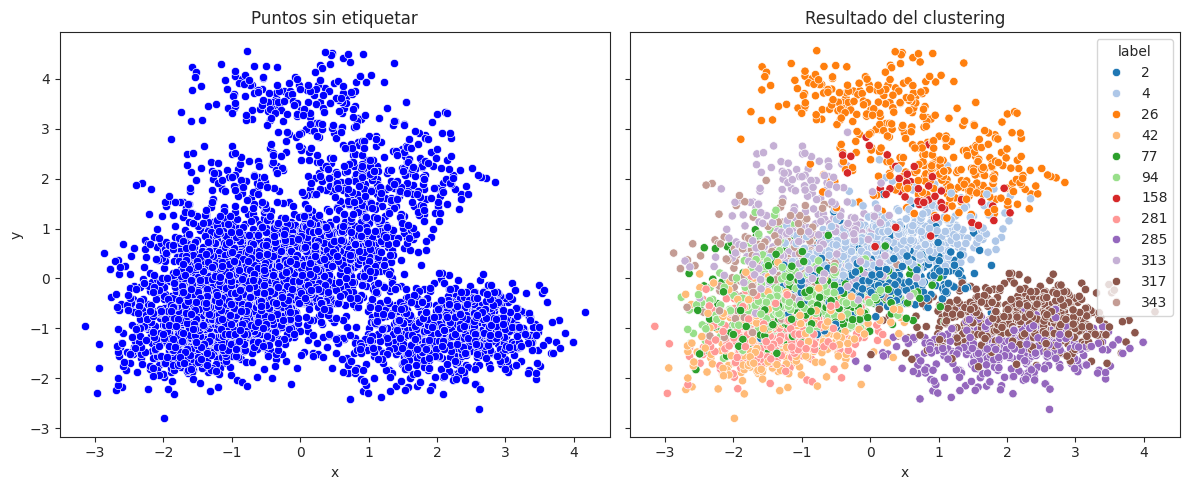

In [23]:
plot_result(X_pca, df_results["component"])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97fa435b-89c8-4b22-a4df-60f2ff3508a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>